# 0. Overview
- Environmnt
  - Environment yields 2 (potentially different) scores. The maximum of these 2 scores is taken.
- Objectives
  - The goal is to get an average score of +0.5 over 100 consecutive episodes.
- Applied algorithms
  - Independent two DDPG agents  

# 1. Setup the environment
- Prepare unity environment with Tennis
- Import required libraries
- Import network

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.Agent import DDPGAgents

# 2.  Get the default brain

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


# 3. Set hyperparameters

In [3]:
ACTION_SIZE = 2
STATE_SIZE = 24

TRAINING_EPISODES = 3000

LR_ACTOR = 1e-3
LR_CRITIC = 1e-3

HIDDEN_UNITS = [64, 64]

GAMMA = 0.99
TAU = 6e-2

EVERY = 100

NUM_AGENTS = 2

EPSILON = 0.3
EPSILON_DECAY = 1e-6

MEMORY_SIZE = int(1e6)
BATCH_SIZE = 128

# 4. Train

Ep: 100	Max Score: 0.10	Average Score in 100 episodes: 0.008
Ep: 200	Max Score: 0.19	Average Score in 100 episodes: 0.024
Ep: 300	Max Score: 0.19	Average Score in 100 episodes: 0.037
Ep: 400	Max Score: 0.20	Average Score in 100 episodes: 0.046
Ep: 500	Max Score: 0.20	Average Score in 100 episodes: 0.052
Ep: 600	Max Score: 0.30	Average Score in 100 episodes: 0.095
Ep: 700	Max Score: 0.40	Average Score in 100 episodes: 0.111
Ep: 800	Max Score: 0.40	Average Score in 100 episodes: 0.139
Ep: 900	Max Score: 2.70	Average Score in 100 episodes: 0.378
Environment solved in 923 epsidoes!	Average Score: 0.50


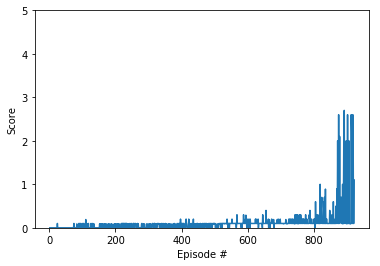

In [4]:
tf.reset_default_graph()

with tf.device("/device:GPU:0"):    
    agents = DDPGAgents(STATE_SIZE, ACTION_SIZE, 1234, MEMORY_SIZE, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, NUM_AGENTS, EPSILON, TAU, EPSILON_DECAY)
save_file = 'model/p3_independent_ddpg.ckpt'
saver = tf.train.Saver()
total_scores = []
step = 0

with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(tf.global_variables_initializer())

    agents.set_session(sess)
    agents.hard_update()

    for ep in range(TRAINING_EPISODES):
        agents.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(NUM_AGENTS)

        while True:
            action = agents.act(state, True)
            
            env_info = env.step(action)[brain_name]
            reward = env_info.rewards
            next_state = env_info.vector_observations
            done = env_info.local_done
            
            agents.step(state, action, reward, next_state, done)
            state = next_state
            scores += list(map(lambda i: reward[i], range(NUM_AGENTS)))
                        
            if np.any(done):
                break
        
        total_scores.append(max(scores))
        if ep > 0 and ep % EVERY == 0:
            print("Ep: {}\tMax Score: {:.2f}\tAverage Score in 100 episodes: {:.3f}"
                  .format(ep, np.max(total_scores), np.mean(total_scores[-100:])))

        if np.mean(total_scores[-100:]) > 0.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep+1, np.mean(total_scores[-100:])))
            saver.save(sess, save_file)            
            break
            
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0, 5])
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

# 5. Validation

INFO:tensorflow:Restoring parameters from model/p3_independent_ddpg.ckpt


Ep: 1, Score: 0.10, Average Score: 0.10
Ep: 2, Score: 2.60, Average Score: 1.35
Ep: 3, Score: 2.70, Average Score: 1.80
Ep: 4, Score: 0.10, Average Score: 1.38
Ep: 5, Score: 2.60, Average Score: 1.62
Ep: 6, Score: 2.70, Average Score: 1.80
Ep: 7, Score: 2.70, Average Score: 1.93
Ep: 8, Score: 2.60, Average Score: 2.01
Ep: 9, Score: 2.70, Average Score: 2.09
Ep: 10, Score: 2.70, Average Score: 2.15
Ep: 11, Score: 2.60, Average Score: 2.19
Ep: 12, Score: 2.70, Average Score: 2.23
Ep: 13, Score: 2.70, Average Score: 2.27
Ep: 14, Score: 1.80, Average Score: 2.24
Ep: 15, Score: 2.60, Average Score: 2.26
Ep: 16, Score: 2.70, Average Score: 2.29
Ep: 17, Score: 0.70, Average Score: 2.19
Ep: 18, Score: 0.20, Average Score: 2.08
Ep: 19, Score: 0.10, Average Score: 1.98
Ep: 20, Score: 2.60, Average Score: 2.01
Ep: 21, Score: 0.10, Average Score: 1.92
Ep: 22, Score: 2.60, Average Score: 1.95
Ep: 23, Score: 0.10, Average Score: 1.87
Ep: 24, Score: 2.60, Average Score: 1.90
Ep: 25, Score: 2.70, Aver

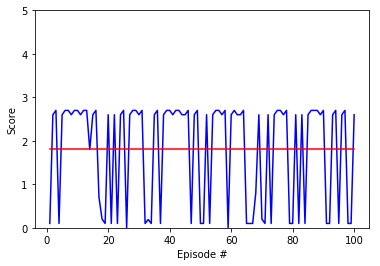

Average Score: 1.81


In [7]:
tf.reset_default_graph()

with tf.device("/device:GPU:0"):
    trained_agents = DDPGAgents(STATE_SIZE, ACTION_SIZE, 1234, MEMORY_SIZE, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, NUM_AGENTS, EPSILON, TAU, EPSILON_DECAY)

save_file = 'model/p3_independent_ddpg.ckpt'
saver = tf.train.Saver()
total_scores = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, save_file)
    trained_agents.set_session(sess)

    for ep in range(100):
        env_info = env.reset(train_mode=True)[brain_name]     
        state = env_info.vector_observations                  
        scores = np.zeros(NUM_AGENTS)                                          
        while True:
            action = trained_agents.act(state, False)
            env_info = env.step(action)[brain_name]           
            state = env_info.vector_observations         
            reward = env_info.rewards                         
            done = env_info.local_done                        
            scores += list(map(lambda i: reward[i], range(NUM_AGENTS)))
            if np.any(done):                                  
                break
        total_scores.append(max(scores))
        print("Ep: {}, Score: {:.2f}, Average Score: {:.2f}".format(ep+1, max(scores), np.mean(total_scores)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0, 5])
x = range(1, len(total_scores)+1)
ax.plot(x, total_scores, color='blue')
ax.plot(x, np.ones_like(x) * np.mean(total_scores), color='red')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   
print('Average Score: {:.2f}'.format(np.mean(total_scores)))

In [8]:
env.close()